In [1]:
import numpy as np
import pickle
from build_database import flux_obj
from scipy import interpolate
from matplotlib import pyplot as plt
from GLD_file_tools import GLD_file_tools
from satellite import Satellite
import datetime
import ephem
from coordinate_structure import coordinate_structure
from coordinate_structure import transform_coords
from longitude_scaling import longitude_scaling
from ionoAbsorp import ionoAbsorp
import os
from mpl_toolkits.basemap import Basemap
from precip_model import precip_model
import itertools
from matplotlib.widgets import Slider
%matplotlib inline

# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'text.fontsize': 14,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------


/Users/austin/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
GLD_root  = 'alex/array/home/Vaisala/feed_data/GLD'
NLDN_root = 'alex/array/home/Vaisala/feed_data/NLDN'

sat_TLE  = ["1 40378U 15003C   15293.75287141  .00010129  00000-0  48835-3 0  9990",
            "2 40378  99.1043 350.5299 0153633 201.4233 158.0516 15.09095095 39471"]

# Satellite object
sat = Satellite(sat_TLE[0], sat_TLE[1],'Firebird 4')
# Lightning-gettin' object
gld = GLD_file_tools(GLD_root, prefix='GLD')

# Column ind
lat_ind = 7;
lon_ind = 8;
mag_ind = 9;

#print os.listdir(GLD_root)


In [128]:
# Input time

inTime = "2015-11-01T00:45:00"
td = datetime.timedelta(seconds = 60) # Maximum time back to check for lightning (pulse can be up to a minute! But how patient are we, really)
plottime = datetime.datetime.strptime(inTime,  "%Y-%m-%dT%H:%M:%S")

print plottime

# Get satellite location
sat.compute(plottime)
sat.coords.transform_to('geomagnetic')

# Get flashes within timeframe:
flashes, flash_times = gld.load_flashes(plottime, td)
flashes = flashes[:,(lat_ind, lon_ind, mag_ind, mag_ind)]
flash_coords = transform_coords(flashes[:,0], flashes[:,1], np.zeros_like(flashes[:,0]), 'geographic', 'geomagnetic')
flashes[:,:2] = flash_coords[:,:2]
flashes[:,3] = [(plottime - s).microseconds*1e-6 + (plottime - s).seconds for s in flash_times]

#print flashes[0:10,:]


2015-11-01 00:45:00
Loaded data shape:  (1, 3)
Loaded data shape:  (3129, 3)


2958 flashes (pre-filter)
1609 flashes (post-filter)
2015-11-01 00:25:00


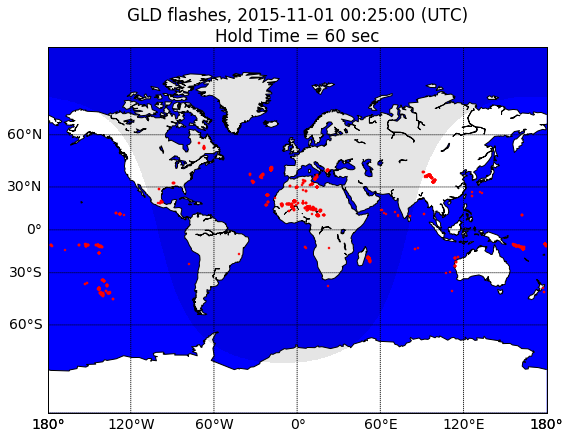

In [118]:
# (Use these to make a nice grid)
# lats = np.linspace(-90,90,90)
# lons = np.linspace(-180,180,90)
# flash_coords = coordinate_structure(lats, lons, [0],'geomagnetic')



print "%g flashes (pre-filter)" % np.shape(flashes)[0]

# Mask out flashes outside the range of the interpolator:
mask = (  (np.abs(flashes[:,0]) > 10) 
        & (np.abs(flashes[:,0]) < 60)) 
        # (flashes[:,2] > 50))

# Mask out flashes not of interest to the satellite:
# atten_factors = longitude_scaling(flash_coords, sat.coords)
# mask = atten_factors < 24

print "%g flashes (post-filter)" % np.sum(mask)

masked_flashes = flashes[mask, :]
#masked_flashes = np.array([masked_coords.lat(), masked_coords.lon(), mMags, mTimes])

#print masked_flashes[0:10,:]



# ------ Basemap Plot -------
map = Basemap(projection='mill',lon_0=0)
map.drawcoastlines()
map.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=[0,0,0,1])
map.drawmapboundary(fill_color='b')
map.fillcontinents(color='white',lake_color='b')

x,y = map(masked_flashes[:,1], masked_flashes[:,0])
#mag = np.log2(abs(flashes[:,9]))
points = map.plot(x,y,'ro',markeredgecolor=[1,0,0], markersize=2)[0]  
print plottime
CS=map.nightshade(plottime,alpha=0.1)

plt.title('GLD flashes, %s (UTC)\nHold Time = %s sec' % (plottime, td.seconds))
plt.draw()

/Users/austin/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: divide by zero encountered in log10


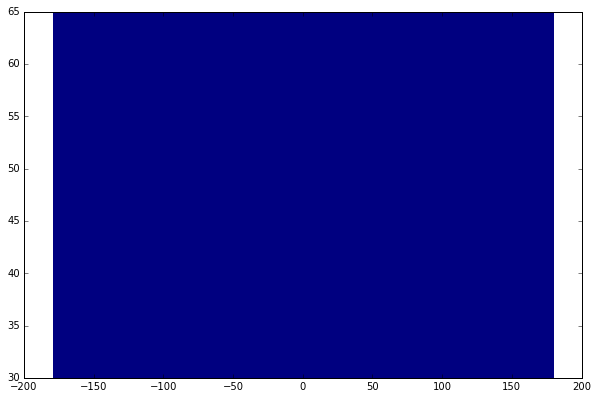

In [134]:
# Generate total precipitation map:
m = precip_model("database_multiple.pkl")
grid_lons = np.linspace(-179,180,360)
grid_lats = np.linspace(30,65, 36)
grid_time = np.linspace(-1*td.seconds,0,td.seconds) #np.linspace(0,30,30)

#print grid_time
N_grid = np.empty([np.size(grid_lons), np.size(grid_lats), np.size(grid_time)])
S_grid = np.empty([np.size(grid_lons), np.size(grid_lats), np.size(grid_time)])

input_lat = masked_flashes[1,0]
out_lat = grid_lats

N_tmp_lat_time = np.empty([np.size(grid_lats), np.size(grid_time)])
S_tmp_lat_time = np.empty([np.size(grid_lats), np.size(grid_time)])


for in_coord in flashes: #masked_flashes:
    input_lat = in_coord[0]
    input_lon = in_coord[1]
    input_mag = in_coord[2]
    input_tim = in_coord[3]
    
    #print "input coords: ", input_lat, input_lon, input_mag, input_tim
    #print "Start time: ", grid_time[0] + input_tim
    for ind_lat, lat in enumerate(grid_lats):

        if input_lat > 0:
            # Northern hemisphere incident flash
            N_tmp_lat_time[ind_lat,:] = m.get_precip_at(input_lat, lat, grid_time + input_tim, "N")
            S_tmp_lat_time[ind_lat,:] = m.get_precip_at(input_lat, lat, grid_time + input_tim, "S")
            
        else:
            # Southern hemisphere incident flash (Assume it's all symmetric, flip north / south)
            N_tmp_lat_time[ind_lat,:] = m.get_precip_at(-1.*input_lat, lat, grid_time + input_tim, "S")
            S_tmp_lat_time[ind_lat,:] = m.get_precip_at(-1.*input_lat, lat, grid_time + input_tim, "N")
            
        ls = m.get_longitude_scaling(input_lat, input_lon, grid_lons, I0=input_mag)
#        tmp_big = np.outer(ls,tmp_lat_time[ind_lat,:])
        #print "tmp_big is:",np.shape(tmp_big)
        N_grid[:,ind_lat,:] += np.outer(ls,N_tmp_lat_time[ind_lat,:])
        S_grid[:,ind_lat,:] += np.outer(ls,S_tmp_lat_time[ind_lat,:])


tt=0
pc = plt.pcolor(grid_lons, grid_lats, np.log10(N_grid[:,:,tt].T))
#plt.scatter(masked_coords.lon(), masked_coords.lat())
plt.clim([-8,4])

plt.show() 



# print np.max(tmp_lat_time)
# print np.min(tmp_lat_time)



[ 30.475549  30.444213  30.410418  30.305664  30.269577  30.25678
  30.246317  30.241571  30.236039  30.223465  30.155974  30.043903
  30.034552  30.02382   30.010019  30.008448  29.97722   29.96151
  29.911687  29.911238  29.85204   29.79581   29.793399  29.717601
  29.712607  29.656299  29.655348  29.627859  29.626937  29.611484
  29.610673  29.590886  29.589782  29.565274  29.554573  29.518332
  29.512282  29.512272  29.49182 ]


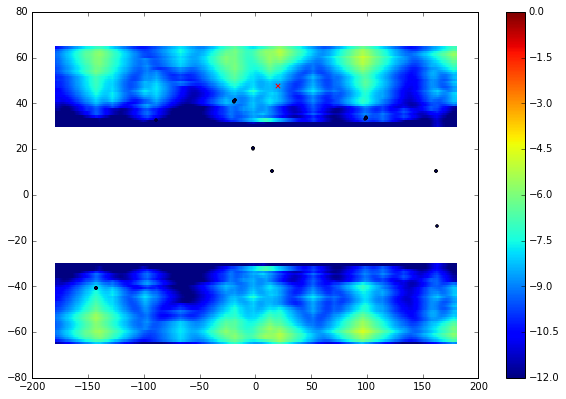

In [143]:
tt=30

tmask = (masked_flashes[:,3] + grid_time[tt] > 0 ) & (masked_flashes[:,3] + grid_time[tt] < 1)
print masked_flashes[tmask,3]
plt.pcolor(grid_lons, grid_lats, np.log10(N_grid[:,:,tt].T))
plt.clim([-12,0])
plt.pcolor(grid_lons, -1*np.flipud(grid_lats), np.fliplr(np.log10(S_grid[:,:,tt])).T)
plt.clim([-12,0])
plt.colorbar()
plt.scatter(masked_flashes[tmask,1], masked_flashes[tmask,0],marker='.')
plt.scatter(sat.coords.lon(), sat.coords.lat(),marker='x',color='red')
#plt.scatter(masked_coords.lon(), masked_coords.lat())
#plt.clim([-12,0])
plt.show() 

# for tt in grid_time:
#     plt.pcolor(grid_lons, grid_lats, np.log10(N_grid[:,:,tt].T))
#     plt.clim([-8,4])
#     plt.show()

In [139]:
np.log10(np.max(N_grid))

-4.4281671917449472